#Projet 7 - Implémentez un modèle de scoring
##Partie 3: Fit du modèle choisi
Dans cette partie, nous fittons le modèle sélectionné dans la partie précédente sur le jeu de données, et nous choisissons le seuil de décision à employer par la suite.

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics, model_selection
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import pickle

from google.colab import files
from google.colab import drive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Imports des packages et des données préparées.

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
fichiers = {'trainX': '126EsHRUCAZxvGI3cI-6hVVdMhzorLMyM',
            'testX': '1ub6d5sgJF-20lqWoXXlt4yjU-bCQs4Eq',
            'trainy': '1-FhtadsMTEZ_IA9G-aZEjGevdcU_TmCJ',
            'testy': '1-3ewg1u6YlrEagab9FFVqtlKrz2eD7af'}

In [4]:
for (i, (k, v)) in enumerate(fichiers.items()):
    downloaded = drive.CreateFile({'id':v})   # replace the id with id of file you want to access
    downloaded.GetContentFile(k + '.csv')        # replace the file name with your file

In [5]:
trainX = pd.read_csv('trainX.csv')
trainX = trainX.set_index(trainX.columns[0])
testX = pd.read_csv('testX.csv')
testX = testX.set_index(testX.columns[0])
trainy = pd.read_csv('trainy.csv')
trainy = trainy.set_index(trainy.columns[0])
testy = pd.read_csv('testy.csv')
testy = testy.set_index(testy.columns[0])

In [6]:
folds = model_selection.KFold(n_splits=5, shuffle=True, random_state=166)

In [7]:
liste_features = [f for f in trainX.columns if f not in ['TARGET',
                                                        'SK_ID_CURR',
                                                        'SK_ID_BUREAU',
                                                        'SK_ID_PREV',
                                                        'index',
                                                        'REFUSED_APP_CREDIT_PERC_MAX',
                                                        'REFUSED_APP_CREDIT_PERC_MAX',
                                                        'PREV_APP_CREDIT_PERC_MAX',
                                                        'PREV_APP_CREDIT_PERC_MEAN',
                                                        'REFUSED_APP_CREDIT_PERC_MEAN',
                                                        'INSTAL_PAYMENT_PERC_MAX',
                                                        'INSTAL_PAYMENT_PERC_MEAN',
                                                        'INSTAL_PAYMENT_PERC_SUM'
                                                        ]]

## Fit modèle

Dans cette partie, je fitte le modèle sélectionné précédemment à mon jeu de données, et j'évalue sa justesse.

In [8]:
# Réference (no skill prediction)
ns_probs = [1 for _ in range(len(testy))]

In [9]:
# fit du modèle
lgbm2 = LGBMClassifier(
                learning_rate = 0.09,
                n_estimators = 550,
                boosting_type = 'dart',
                num_leaves = 16,
                class_weight = 'balanced'
                )
lgbm2.fit(np.nan_to_num(trainX), trainy)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.09, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=550,
               n_jobs=-1, num_leaves=16, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

No Skill: ROC AUC=0.500
LGBM: ROC AUC=0.784


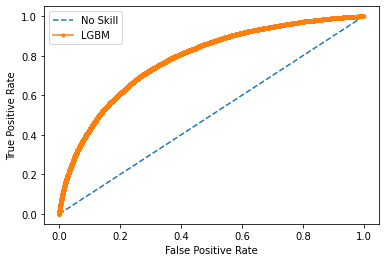

In [10]:
# Evaluation du modèle

# Predict proba 
lgbm2_probs = lgbm2.predict_proba(np.nan_to_num(testX))

# Je ne garde que la prédiction positive (défaut de paiement)
probas = lgbm2_probs.copy()
lgbm2_probs = lgbm2_probs[:, 1]
lgbm2_pred = lgbm2.predict(np.nan_to_num(testX))

# Je calcule le score AUC
ns_auc = roc_auc_score(testy, ns_probs)
lgbm2_auc = roc_auc_score(testy, lgbm2_probs)
lgbm2_acc = accuracy_score(testy, lgbm2_pred)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm2_auc))

# Je calcule et affiche les courbes ROC
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lgbm2_fpr, lgbm2_tpr, _ = roc_curve(testy, lgbm2_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lgbm2_fpr, lgbm2_tpr, marker='.', label='LGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Recherche du seuil optimal
Une problématique majeure est le seuil de décision: à partir de quelle note (predict_proba) faut-il accorder le prêt?
Cette décision se fait en comparant, pour toute une liste de seuils possibles, la perte possible au gain possible.


Pour cette estimation, je considère un rapport 1/10 entre le gain possible et la perte possible pour un candidat donné.

In [ ]:
seuils = []
coût = []
y_pred = lgbm2.predict_proba(trainX)[:,1]
for s in range(0, 1000, 1):
  y_pred_s = (y_pred >= s/1000).astype(bool)
  mat = metrics.confusion_matrix(y_pred_s, trainy)
  seuils.append(s/1000)
  coût.append(10*mat[0,1] + mat[1,0])

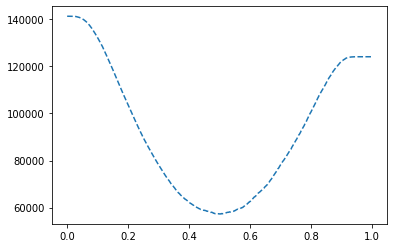

In [ ]:
plt.plot(seuils, coût, linestyle='--', label='Coût = f(seuil')

J'obtiens alors le seuil optimal (seuil de choix où le gain sera maximal) suivant:

In [ ]:
seuil = seuils[np.where(coût == min(coût))[0][0]]
print("Seuil optimal:", str(seuil))

Seuil optimal: 0.505


Par curiosité, je peux faire la même expérience avec un seuil gain/perte de 1/5.

In [ ]:
Echelle_seuil = [0, min(0.6*seuil,1), min(0.9*seuil,1), min(seuil,1),min(1.2*seuil,1), 1]

In [ ]:
seuils2 = []
coût = []
y_pred = lgbm2.predict_proba(trainX)[:,1]
for s in range(0, 1000, 1):
  y_pred_s = (y_pred >= s/1000).astype(bool)
  mat = metrics.confusion_matrix(y_pred_s, trainy)
  seuils2.append(s/1000)
  coût.append(5*mat[0,1] + mat[1,0])

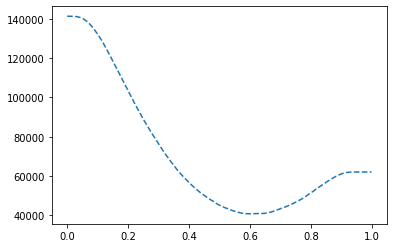

In [ ]:
plt.plot(seuils2, coût, linestyle='--', label='Coût = f(seuil')

In [ ]:
seuil2 = seuils2[np.where(coût == min(coût))[0][0]]
print("Seuil optimal:", str(seuil2))

Seuil optimal: 0.601


## Export du modèle
J'exporte le modèle fitté pour futur usage.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
type(lgbm2)

lightgbm.sklearn.LGBMClassifier

In [ ]:
filename = 'classification_credit_2.sav'
out = open(os.path.join("/content/drive/My Drive/Colab_Notebooks", filename), 'wb')
joblib.dump(lgbm2, out)

NameError: ignored

In [ ]:
joblib.load('classification_credit_2.sav')

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.08, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=26, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)